In [ ]:
# !pip install finance-datareader
# !pip install yfinance

In [ ]:
# https://dacon.io/competitions/official/235980/codeshare/6634?page=1&dtype=random

In [ ]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
import FinanceDataReader as fdr
import seaborn as sns
from matplotlib import rc
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import cvxopt as opt
from cvxopt import solvers
import warnings
warnings.filterwarnings(action='ignore')

### 1. CAPM분석

- CAPM:자본시장이 균형상태를 이룰 때 자본자산의 기대수익과 위험의 관계를 설명함
- 주식, 채권, 등의 자본 수익률과 위험 과의 관계를 도출

####1-1 Kospi

In [ ]:
#1996.12.11부터 2022.12.22까지의 일별 KOSPI데이터
#Open: 시가
#High: 고가
#Low: 저가
#Close: 종가
#Adj Close: 수정 종가
#Volume: 거래량

In [ ]:
kospi_data = fdr.DataReader('KS11')
kospi = kospi_data.copy()
kospi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6567 entries, 1996-12-11 to 2022-12-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6418 non-null   float64
 1   High       6418 non-null   float64
 2   Low        6418 non-null   float64
 3   Close      6418 non-null   float64
 4   Adj Close  6418 non-null   float64
 5   Volume     6418 non-null   float64
dtypes: float64(6)
memory usage: 359.1 KB


In [ ]:
#Change: 등락률(전일대비 등락률)
#등락률 = (현재 종가 - 전일 종가) / 전일 종가
kospi = kospi.reset_index()
kospi['Change'] = round(kospi['Adj Close'].pct_change()*100,2)
kospi['Date'] = pd.to_datetime(kospi['Date'])
kospi.drop(['Open','High','Low','Close','Adj Close','Volume'],axis=1,inplace=True)
kospi.drop(kospi.tail(1).index,inplace=True)
kospi = kospi.set_index('Date')
kospi.rename(columns={'Change':'KOSPI'},inplace=True)
kospi

,KOSPI
Date,
1996-12-11,NaN
1996-12-12,-2.17
1996-12-13,-0.04
1996-12-16,-2.20
1996-12-17,-1.57
...,...
2022-12-16,-0.04
2022-12-19,-0.33
2022-12-20,-0.80


#### 1-2. Nasdq

In [ ]:
nasdaq_data = yf.download('^IXIC',start = '1996-12-11', end = '2022-12-22')
nasdaq = nasdaq_data.copy()

[*********************100%***********************]  1 of 1 completed


In [ ]:
nasdaq['Change'] = round(nasdaq['Adj Close'].pct_change()*100,2)
nasdaq.drop(['Open','High','Low','Close','Adj Close','Volume'],axis=1,inplace=True)
nasdaq.rename(columns={'Change':'NASDAQ'},inplace=True)
nasdaq

,NASDAQ
Date,
1996-12-11,NaN
1996-12-12,-0.82
1996-12-13,-1.03
1996-12-16,-1.86
1996-12-17,0.42
...,...
2022-12-15,-3.23
2022-12-16,-0.97
2022-12-19,-1.49


#### 1-3. S&P데이터 불러오기

In [ ]:
sap = yf.download('^GSPC', start = '1996-12-11', end = '2022-12-22')
sap['Change'] = round(sap['Adj Close'].pct_change() * 100, 2)
sap.drop(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], axis = 1, inplace = True)
sap.rename(columns = {'Change':'S&P'},inplace=True)
sap

[*********************100%***********************]  1 of 1 completed


,S&P
Date,
1996-12-11,NaN
1996-12-12,-1.54
1996-12-13,-0.09
1996-12-16,-1.05
1996-12-17,0.70
...,...
2022-12-15,-2.49
2022-12-16,-1.11
2022-12-19,-0.90


#### 1.4 미국 10년 국채

In [ ]:
usa_treasury = yf.download('^TNX', start = '1996-12-11', end = '2022-12-22')
usa_treasury['Change'] = round(usa_treasury['Adj Close'].pct_change() * 100, 2)
usa_treasury.drop(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], axis = 1, inplace = True)
usa_treasury.rename(columns={'Change':'USA_TREASURT'},inplace=True)
usa_treasury

[*********************100%***********************]  1 of 1 completed


,USA_TREASURT
Date,
1996-12-11,NaN
1996-12-12,0.47
1996-12-13,-1.00
1996-12-16,0.74
1996-12-17,0.53
...,...
2022-12-15,-1.51
2022-12-16,0.93
2022-12-19,2.84


### 1.5 Nikkei

In [ ]:
jpan = yf.download('^N225', start = '1996-12-11', end = '2022-12-22')
jpan['Change'] = round(jpan['Adj Close'].pct_change() * 100, 2)
jpan.drop(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], axis = 1, inplace = True)
jpan.rename(columns={'Change':'Nikkei'},inplace=True)
jpan

[*********************100%***********************]  1 of 1 completed


,Nikkei
Date,
1996-12-11,NaN
1996-12-12,-0.33
1996-12-13,-0.78
1996-12-16,0.40
1996-12-17,-0.04
...,...
2022-12-15,-0.37
2022-12-16,-1.87
2022-12-19,-1.05


### 1.6 달러환율

In [ ]:
dollar = yf.download('USDKRW=X',start = '1996-12-11',end = '2022-12-21')
dollar['Change'] = round(dollar['Adj Close'].pct_change() * 100, 2)
dollar.drop(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], axis = 1, inplace = True)
dollar.rename(columns={'Change':'dollar'},inplace=True)
dollar

[*********************100%***********************]  1 of 1 completed


,dollar
Date,
2003-12-01,NaN
2003-12-02,-0.28
2003-12-03,-0.21
2003-12-04,-0.20
2003-12-05,-0.45
...,...
2022-12-14,-1.30
2022-12-15,0.52
2022-12-16,1.65


### 2.지수 데이터 병합

In [ ]:
result_data = pd.concat([kospi, nasdaq, sap, usa_treasury, jpan, dollar], axis = 1)
result_data

,KOSPI,NASDAQ,S&P,USA_TREASURT,Nikkei,dollar
Date,,,,,,
1996-12-11,NaN,NaN,NaN,NaN,NaN,NaN
1996-12-12,-2.17,-0.82,-1.54,0.47,-0.33,NaN
1996-12-13,-0.04,-1.03,-0.09,-1.00,-0.78,NaN
1996-12-16,-2.20,-1.86,-1.05,0.74,0.40,NaN
1996-12-17,-1.57,0.42,0.70,0.53,-0.04,NaN
...,...,...,...,...,...,...
2022-12-16,-0.04,-0.97,-1.11,0.93,-1.87,1.65
2022-12-19,-0.33,-1.49,-0.90,2.84,-1.05,-0.63
2022-12-20,-0.80,0.01,0.10,2.88,-2.46,-0.58


In [ ]:
result_data = result_data.dropna()
result_data.isnull().sum()

KOSPI           0
NASDAQ          0
S&P             0
USA_TREASURT    0
Nikkei          0
dollar          0
dtype: int64

In [ ]:
# #결측값 있는 인덱스 추출

# kospi_idx = result_data['KOSPI'][result_data['KOSPI'].isnull()].index
# nasdaq_idx = result_data['NASDAQ'][result_data['NASDAQ'].isnull()].index.tolist()
# sap_idx = result_data['S&P'][result_data['S&P'].isnull()].index
# usa_treasurt_idx = result_data['USA_TREASURT'][result_data['USA_TREASURT'].isnull()].index
# Nikkei_idx = result_data['Nikkei'][result_data['Nikkei'].isnull()].index
# dollar_idx = result_data['dollar'][result_data['dollar'].isnull()].index

### 3.군집분석

In [ ]:
result_data

,KOSPI,NASDAQ,S&P,USA_TREASURT,Nikkei,dollar
Date,,,,,,
2003-12-02,0.05,-0.49,-0.33,-0.27,0.07,-0.28
2003-12-03,0.07,-1.00,-0.18,0.68,-0.80,-0.21
2003-12-04,-0.40,0.44,0.47,-0.93,1.00,-0.20
2003-12-05,-1.95,-1.57,-0.77,-3.52,-0.54,-0.45
2003-12-08,-0.58,0.57,0.73,1.49,-3.16,0.08
...,...,...,...,...,...,...
2022-12-14,1.13,-0.76,-0.61,0.06,0.72,-1.30
2022-12-15,-1.60,-3.23,-2.49,-1.51,-0.37,0.52
2022-12-16,-0.04,-0.97,-1.11,0.93,-1.87,1.65


In [ ]:
x = result_data[['KOSPI','NASDAQ','S&P','USA_TREASURT','Nikkei','dollar']]
y = result_data['KOSPI']

In [ ]:
ks = range(1,10)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k,random_state=42)
    model.fit(x)
    inertias.append(model.inertia_)

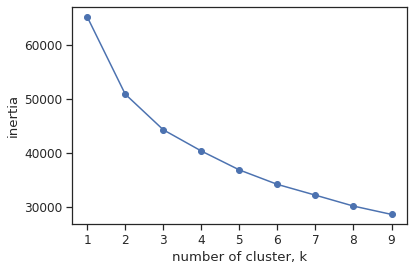

In [ ]:
#N=4일 때 최적의 분류로 확인함
plt.plot(ks, inertias, '-o')
plt.xlabel('number of cluster, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
#4로 군집화
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=35)
kmeans.fit(x)
y_kmeans = kmeans.predict(x)
#군집화된 결과
y_kmeans[1:10]

array([1, 2, 3, 1, 2, 1, 2, 2, 2], dtype=int32)

In [ ]:
import time
from sklearn.manifold import TSNE

n_sne = x.shape[0]
time_start = time.time()
tsne = TSNE(n_components=2,verbose=1,perplexity=32,n_iter=1000,random_state=0,angle=0.5)
tsne_results = tsne.fit_transform(x)

[t-SNE] Computing 97 nearest neighbors...
[t-SNE] Indexed 4312 samples in 0.006s...
[t-SNE] Computed neighbors for 4312 samples in 0.333s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4312
[t-SNE] Computed conditional probabilities for sample 2000 / 4312
[t-SNE] Computed conditional probabilities for sample 3000 / 4312
[t-SNE] Computed conditional probabilities for sample 4000 / 4312
[t-SNE] Computed conditional probabilities for sample 4312 / 4312
[t-SNE] Mean sigma: 0.537979
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.427811
[t-SNE] KL divergence after 1000 iterations: 1.661507


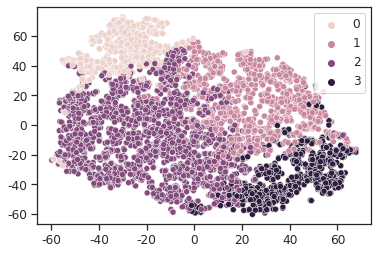

In [ ]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_kmeans, s=20, cmap='bwr')
sns.scatterplot(tsne_results[:,0], tsne_results[:,1],data=result_data,hue=y_kmeans,cmap='bwr')
plt.show()

In [ ]:
df1 = result_data.copy()
df1['cluster'] = y_kmeans
df1

,KOSPI,NASDAQ,S&P,USA_TREASURT,Nikkei,dollar,cluster
Date,,,,,,,
2003-12-02,0.05,-0.49,-0.33,-0.27,0.07,-0.28,2
2003-12-03,0.07,-1.00,-0.18,0.68,-0.80,-0.21,1
2003-12-04,-0.40,0.44,0.47,-0.93,1.00,-0.20,2
2003-12-05,-1.95,-1.57,-0.77,-3.52,-0.54,-0.45,3
2003-12-08,-0.58,0.57,0.73,1.49,-3.16,0.08,1
...,...,...,...,...,...,...,...
2022-12-14,1.13,-0.76,-0.61,0.06,0.72,-1.30,2
2022-12-15,-1.60,-3.23,-2.49,-1.51,-0.37,0.52,3
2022-12-16,-0.04,-0.97,-1.11,0.93,-1.87,1.65,1


In [ ]:
df1['cluster'].unique()

array([2, 1, 3, 0], dtype=int32)

In [ ]:
cluster_3 = df1[df1['cluster']==3]
cluster_2 = df1[df1['cluster']==2]
cluster_1 = df1[df1['cluster']==1]
cluster_0 = df1[df1['cluster']==0]

In [ ]:
cluster_0

,KOSPI,NASDAQ,S&P,USA_TREASURT,Nikkei,dollar,cluster
Date,,,,,,,
2004-01-23,0.00,0.23,-0.21,2.44,0.62,-1.05,0
2004-03-26,1.24,-0.36,-0.10,2.78,2.08,0.07,0
2004-04-02,0.11,2.09,0.85,6.21,1.13,1.95,0
2004-05-07,0.13,-1.02,-1.37,3.56,-1.15,-0.51,0
2004-07-27,0.31,1.64,0.99,2.68,-1.15,-0.01,0
...,...,...,...,...,...,...,...
2022-09-26,-3.02,-0.60,-1.03,4.90,-2.66,1.29,0
2022-10-05,0.26,-0.25,-0.20,3.93,0.48,-1.17,0
2022-10-19,-0.56,-0.85,-0.67,3.23,0.37,-0.36,0


In [ ]:
#군집의 0~3까지의 수익률 확인

cluster_total = df1.groupby('cluster').mean()
cluster_total['return'] = cluster_total.T.mean()
cluster_total['std'] = cluster_total.T.std()
cluster_total = cluster_total.T
cluster_total

cluster,0,1,2,3
KOSPI,0.402351,-0.992383,0.550279,-0.236063
NASDAQ,0.831959,-0.237758,0.352591,-1.129581
S&P,0.793563,-0.157664,0.286616,-1.067859
USA_TREASURT,4.236586,-0.003752,0.057101,-3.398862
Nikkei,0.436381,-1.306876,0.682478,-0.155284
dollar,0.015634,0.221135,-0.105073,0.046617
return,1.119412,-0.412883,0.303999,-0.990172
std,1.420365,0.547755,0.269216,1.166755


- 군집0: USA_TREASURT가 메인으로 이뤄진 군집
- 군집1:dollar가 메인으로 이뤄진 군집
- 군집2:위험자산으로 이뤄진 군집
- 군집3: dollar가 메인으로 이뤄진 군집

금융시장의 수익률: 국채>위험자산>달러
금융시장의 표준편차(위험): 달러>USA_TESASURT>위험자산

### 8.군집별 수익률 대비 risk 시각화

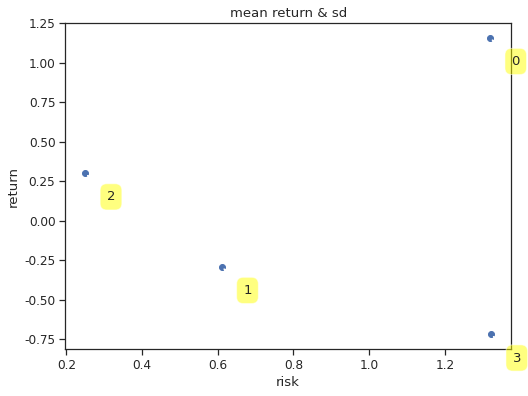

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(cluster_total.std(), cluster_total.mean())
plt.xlabel('risk')
plt.ylabel('return')
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('mean return & sd')
for label, x, y in zip(cluster_total.columns, cluster_total.std(), cluster_total.mean()):
    plt.annotate(label, xy=(x, y), xytext=(30, -30),
    textcoords = 'offset points',
    ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

#### 4.상관관계 분석

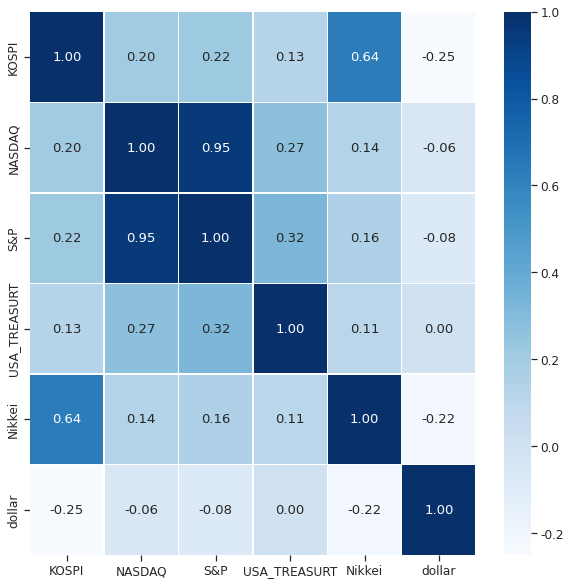

In [ ]:
#히트맵
df2 = df1.corr()
plt.figure(figsize=(10,10))
sns.heatmap(result_data.corr(),annot=True,fmt='.2f',linewidths=.5,cmap='Blues')

In [ ]:
#상관관계 계수 확인
idx, vals = [], []
for ix, i in enumerate(result_data.columns.values):
    for j in result_data.columns.values[ix + 1:]:
        idx.append((i, j))
        vals.append(result_data.corr()[i][j])

ser = pd.Series(data=vals, index=idx)
ser_ord = ser.sort_values(ascending=False)
ser_ord

(NASDAQ, S&P)             0.948866
(KOSPI, Nikkei)           0.635469
(S&P, USA_TREASURT)       0.320950
(NASDAQ, USA_TREASURT)    0.274568
(KOSPI, S&P)              0.220962
(KOSPI, NASDAQ)           0.204292
(S&P, Nikkei)             0.155542
(NASDAQ, Nikkei)          0.135736
(KOSPI, USA_TREASURT)     0.129676
(USA_TREASURT, Nikkei)    0.112011
(USA_TREASURT, dollar)    0.000971
(NASDAQ, dollar)         -0.057364
(S&P, dollar)            -0.078815
(Nikkei, dollar)         -0.218825
(KOSPI, dollar)          -0.251136
dtype: float64

- kospi와의 상관관계
1. Nikkei > S&P > Nasdaq > USA_TREASURT > dollar
- Nasdaq와 S&P의 상관관계가 높음

In [ ]:
result_data.columns

Index(['KOSPI', 'NASDAQ', 'S&P', 'USA_TREASURT', 'Nikkei', 'dollar'], dtype='object')

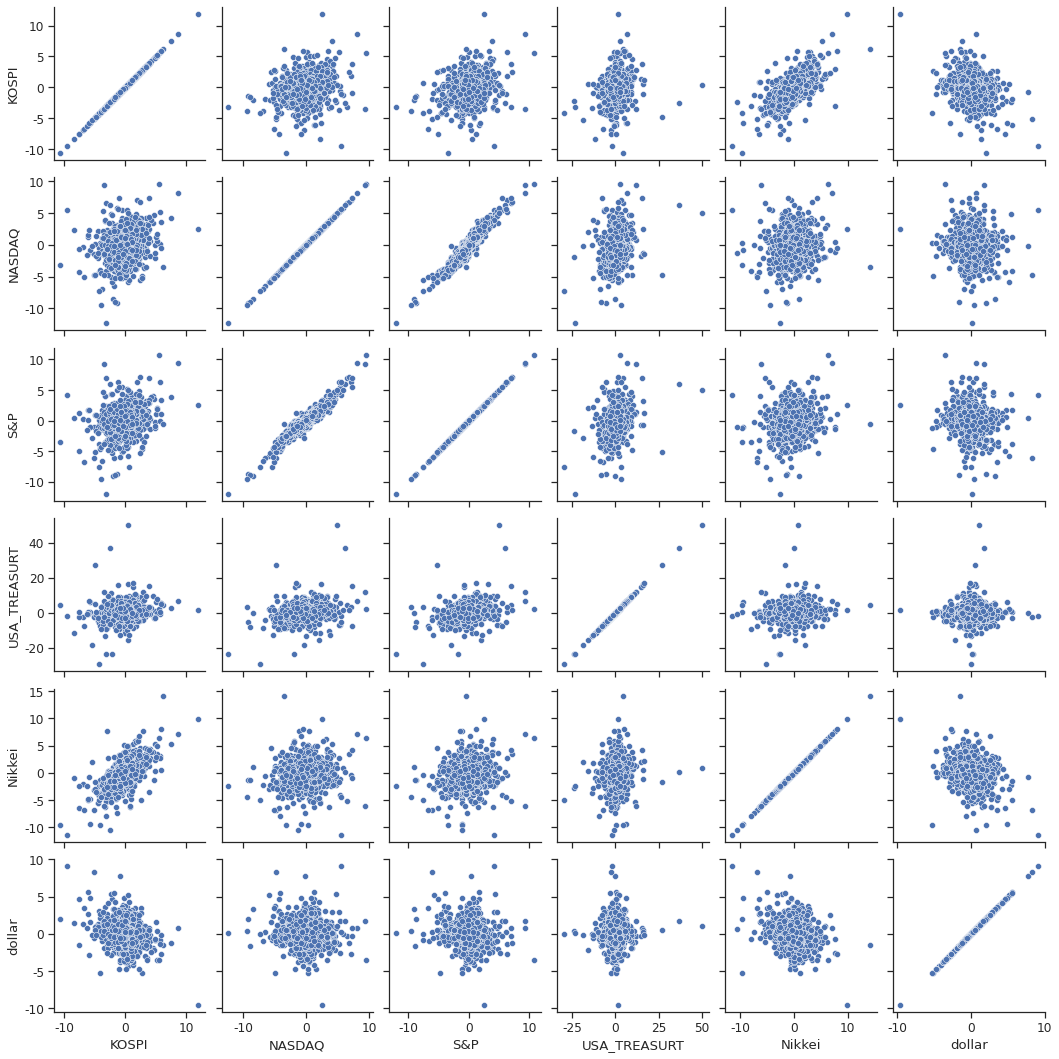

In [ ]:
#산점도 그래프
sns.set(font_scale=1.1)
sns.set_style('ticks')
data = result_data[['KOSPI', 'NASDAQ', 'S&P', 'USA_TREASURT', 'Nikkei', 'dollar']]
sns.pairplot(data,diag_kind=None)
plt.show()

### 5.세계 지수의 수익률 대비 risk시각화

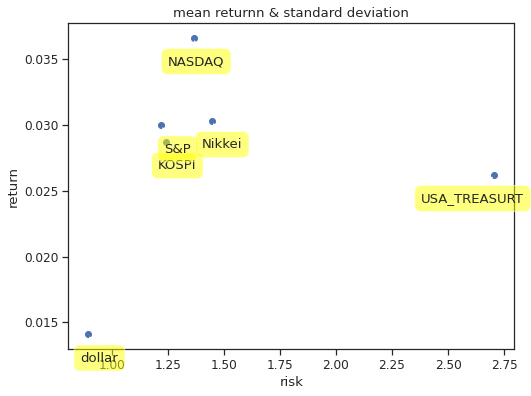

In [ ]:
#평균 수익률 및 표준편차
plt.figure(figsize=(8,6))
plt.scatter(result_data.std(), result_data.mean())
plt.xlabel('risk')
plt.ylabel('return')
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('mean returnn & standard deviation')

for label, x, y in zip(result_data.columns, result_data.std(), result_data.mean()):
    plt.annotate(label, xy=(x, y), xytext=(30, -30),
    textcoords = 'offset points',
    ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

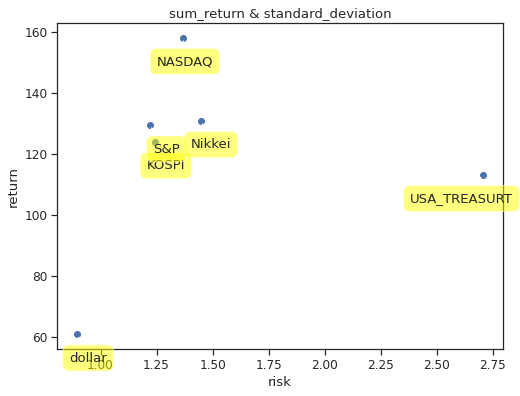

In [ ]:
#누적 수익률 및 표준편차
plt.figure(figsize=(8,6))
plt.scatter(result_data.std(),result_data.sum())
plt.xlabel('risk')
plt.ylabel('return')

rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('sum_return & standard_deviation')
for label, x, y in zip(result_data.columns, result_data.std(), result_data.sum()):
    plt.annotate(label, xy=(x, y), xytext=(30, -30),
    textcoords = 'offset points',
    ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

- 안전자산인 dollar는 수익률과 위험이 모두 낮다.
- 미국 채권의 경우 위험은 높고 수익률은 중간이다.
- S&P, Nikkei, KOSPI는 수익률이 높지만 위험률은 낮은 편이다.
- NASDAQ은 수익률이 가장 높고 위험율은 낮은 편이다.

### 6.CAPM(자본자산 가격결정 모형)

- CAPM: 자본시장이 균형상태(시장에서 수요와 공급이 일치되도록 가격이 형성된 상태)에 있을 때, (자본)자산의 균형가격이 위험을 반영하여 어떻게 결정되는지를 보여주는 모형
- 자본시장의 균형하에서 위험이 존재하는 자산의 균형수익률을 도출해내는 모형

CAPM : E(R) = rf + B[E(rm) -rf)]

- E(R) = 기대수익률
- rf = 무위험수익률
- B = 베타
- E(rm) - rf = 위험프리미엄

In [ ]:
# 기대수익률
def rand_weights(n):
    k = np.random.rand(n)
    return k / sum(k)
rand_weights(6)

array([0.07787504, 0.33412674, 0.13686978, 0.03543234, 0.1303199 ,
       0.28537619])

### cluster_0 포트폴리오 작성

In [ ]:
cluster_0.drop('cluster',axis=1,inplace=True)
cluster_0

,KOSPI,NASDAQ,S&P,USA_TREASURT,Nikkei,dollar
Date,,,,,,
2004-01-23,0.00,0.23,-0.21,2.44,0.62,-1.05
2004-03-26,1.24,-0.36,-0.10,2.78,2.08,0.07
2004-04-02,0.11,2.09,0.85,6.21,1.13,1.95
2004-05-07,0.13,-1.02,-1.37,3.56,-1.15,-0.51
2004-07-27,0.31,1.64,0.99,2.68,-1.15,-0.01
...,...,...,...,...,...,...
2022-09-26,-3.02,-0.60,-1.03,4.90,-2.66,1.29
2022-10-05,0.26,-0.25,-0.20,3.93,0.48,-1.17
2022-10-19,-0.56,-0.85,-0.67,3.23,0.37,-0.36


In [ ]:
returns_matrix = cluster_0.values.T
pd.DataFrame(returns_matrix)

,0,1,2,3,4,5,6,7,8,9,...,526,527,528,529,530,531,532,533,534,535
0,0.00,1.24,0.11,0.13,0.31,-0.47,1.11,0.56,0.00,0.85,...,0.72,-0.61,-2.28,0.26,-0.63,-3.02,0.26,-0.56,-0.89,-0.49
1,0.23,-0.36,2.09,-1.02,1.64,2.14,0.76,-0.76,0.03,-0.59,...,-0.50,-2.01,-0.26,-0.74,-1.37,-0.60,-0.25,-0.85,2.87,1.13
2,-0.21,-0.10,0.85,-1.37,0.99,1.29,0.39,-0.21,0.42,-1.02,...,-0.16,-1.29,0.30,-0.41,-0.84,-1.03,-0.20,-0.67,2.46,0.75
3,2.44,2.78,6.21,3.56,2.68,2.48,2.90,2.67,2.41,3.18,...,6.13,3.78,4.21,4.60,5.64,4.90,3.93,3.23,1.85,2.44
4,0.62,2.08,1.13,-1.15,-1.15,0.18,1.06,-0.29,0.70,0.67,...,0.87,-0.04,-1.53,0.02,-0.58,-2.66,0.48,0.37,-0.88,-0.40
5,-1.05,0.07,1.95,-0.51,-0.01,-0.21,1.78,-0.58,0.09,-0.29,...,-0.41,0.92,-0.59,0.02,0.36,1.29,-1.17,-0.36,0.56,-0.43


In [ ]:
#가중치를 기반으로 랜덤포트폴리오 작성
def random_portfolio(returns):
    p = np.asmatrix(np.mean(returns,axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))

    mu = w * p.T
    sigma = np.sqrt(w*C*w.T)

    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma, w

In [ ]:
random_portfolio(returns_matrix)

(matrix([[0.66256012]]),
 matrix([[0.98419027]]),
 matrix([[0.18607138, 0.11685187, 0.27073536, 0.03333245, 0.30486853,
          0.08814041]]))

In [ ]:
#500개의 무작위 포트폴리오 생성
output = []
for i in range(0,500):
    port_mean, port_std, weights = random_portfolio(returns_matrix)
    mean_std_array = np.array([port_mean, port_std])
    weights_array = np.array(weights)
    merged_array = np.concatenate((mean_std_array, weights_array),axis=None)
    merged_list = merged_array.tolist()
    output.append(merged_list)
    col_list = list(result_data.columns)
    col_list = [i + '_W' for i in col_list]

    df_col = ['Port_ret','Port_std'] + col_list
    port_ret_var = pd.DataFrame(output, columns=df_col)

In [ ]:
port_ret_var

,Port_ret,Port_std,KOSPI_W,NASDAQ_W,S&P_W,USA_TREASURT_W,Nikkei_W,dollar_W
0,1.122912,0.978987,0.224231,0.081832,0.244107,0.164991,0.160295,0.124544
1,1.055696,0.898793,0.151459,0.165229,0.130284,0.159230,0.173874,0.219925
2,1.234566,1.117057,0.110253,0.206035,0.199843,0.171118,0.309825,0.002926
3,0.792997,0.784916,0.251927,0.126617,0.107830,0.103897,0.128703,0.281027
4,0.692424,0.797557,0.204038,0.047545,0.109185,0.084307,0.281115,0.273810
...,...,...,...,...,...,...,...,...
495,0.819896,0.823052,0.170495,0.144400,0.183973,0.098105,0.150292,0.252734
496,0.984846,0.964501,0.183014,0.190238,0.183817,0.120885,0.213652,0.108394
497,0.867087,0.950294,0.228638,0.244360,0.078898,0.093763,0.252914,0.101426
498,1.382987,1.165691,0.110953,0.368755,0.129733,0.213698,0.048695,0.128165


In [ ]:
#평균 수익률
means = port_ret_var['Port_ret'].values
#표준편차(위험률)
stds = port_ret_var['Port_std'].values

Text(0.5, 1.0, 'portfolio returns & standard deviation')

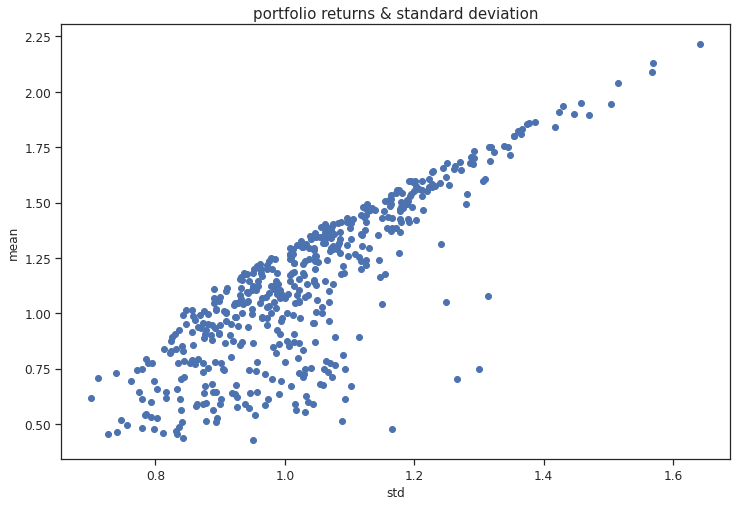

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(stds,means,'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('portfolio returns & standard deviation', fontsize = 15)

In [ ]:
#가중치를 최소화

def minimum_port_weight(returns):
  mean_ret = np.mean(returns,axis=1)
  cov_ret = np.cov(returns)
  n = mean_ret.shape[0]
  one_array = np.ones(n)

  #List of target portfolio returns (목표 포트폴리오 수익률 리스트) > 이 부분을 군집별 포트폴리오마다 수정해줘야 합니다.
  mus = list(np.arange(-0.2,0.1,0.01))

  # Convert to cvxopt matrices (cvxopt matrix로 변환)
  Q = opt.matrix(cov_ret)
  p = opt.matrix(0.0, (n, 1))

  # Create constraint matrices (최적화 문제 제약조건 설정)
  A = opt.matrix(np.stack((mean_ret,one_array)))
  weights_list = []
  mean_std_list = []
  for mu in mus:
    b = opt.matrix(np.array([mu,1]))
    weights = solvers.qp(Q, p, A = A, b = b)['x']
    weight_array = np.array(list(weights))
    port_ret = np.matrix(weight_array).dot(np.matrix(mean_ret).T)
    port_std = np.sqrt(np.matrix(weight_array).dot(np.matrix(cov_ret)).dot(np.matrix(weight_array).T))

    weights_list.append(list(weights))
    mean_std_list.append([port_ret[0,0],port_std[0,0]])

  return weights_list,mean_std_list

In [ ]:
weights, mean_stds = minimum_port_weight(returns_matrix)
col_name = result_data.columns + '_Weight'
weights_df = pd.DataFrame(weights,columns = col_name)
mean_stds_df = pd.DataFrame(mean_stds,columns=['Port_ret','Port_std'])

Text(0.5, 1.0, 'Minimum variance frontier for risky assets(cluster_0)')

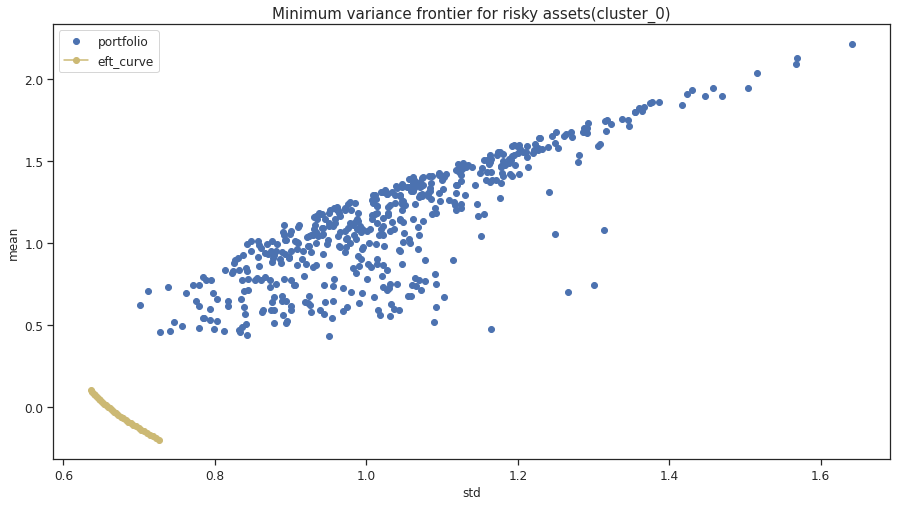

In [ ]:
# Plot minimum variance frontier (최소 분산 곡선 그래프)
# Random portfolios (무작위 포트폴리오)
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

# Minimum varaince portfolios (최소분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']

fig = plt.figure(figsize=(15,8))
plt.plot(stds, means, 'o', label = 'portfolio')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o', label = 'eft_curve')
plt.legend()
plt.title('Minimum variance frontier for risky assets(cluster_0)',fontsize=15)

### cluster_1 포트폴리오 작성

In [ ]:
cluster_1.drop('cluster', axis = 1, inplace = True)
returns_matrix = cluster_1.values.T
#Generate 500 random portfolio (500개의 무작위 포트폴리오 생성)
output = []
for i in range(0,500):
  port_mean, port_std, weights = random_portfolio(returns_matrix)
  mean_std_array = np.array([port_mean, port_std])
  weights_array = np.array(weights)
  merged_array = np.concatenate((mean_std_array,weights_array),axis=None)
  merged_list = merged_array.tolist()
  output.append(merged_list)

col_list = list(result_data.columns)
col_list = [i + '_W' for i in col_list]

df_col = ['Port_ret','Port_std'] + col_list
port_ret_var = pd.DataFrame(output,columns = df_col)
port_ret_var

,Port_ret,Port_std,KOSPI_W,NASDAQ_W,S&P_W,USA_TREASURT_W,Nikkei_W,dollar_W
0,-0.576927,0.592726,0.149101,0.216080,0.163884,0.058401,0.289759,0.122774
1,-0.489381,0.513064,0.240297,0.202943,0.024865,0.080448,0.195202,0.256244
2,-0.226931,0.546507,0.020079,0.263125,0.079461,0.288182,0.136154,0.212999
3,-0.319374,0.549862,0.183557,0.298007,0.055819,0.266884,0.065342,0.130391
4,-0.259306,0.518137,0.227645,0.085531,0.234678,0.246573,0.013477,0.192096
...,...,...,...,...,...,...,...,...
495,-0.744029,0.695215,0.149426,0.171074,0.198490,0.038611,0.406710,0.035689
496,-0.152218,0.529715,0.033052,0.214024,0.028255,0.220965,0.114289,0.389416
497,-0.168688,0.528573,0.105150,0.167535,0.037109,0.136820,0.091959,0.461427
498,-0.609051,0.653600,0.111221,0.339322,0.101083,0.115067,0.311082,0.022224


Text(0.5, 1.0, 'portfolio returns & standard deviation')

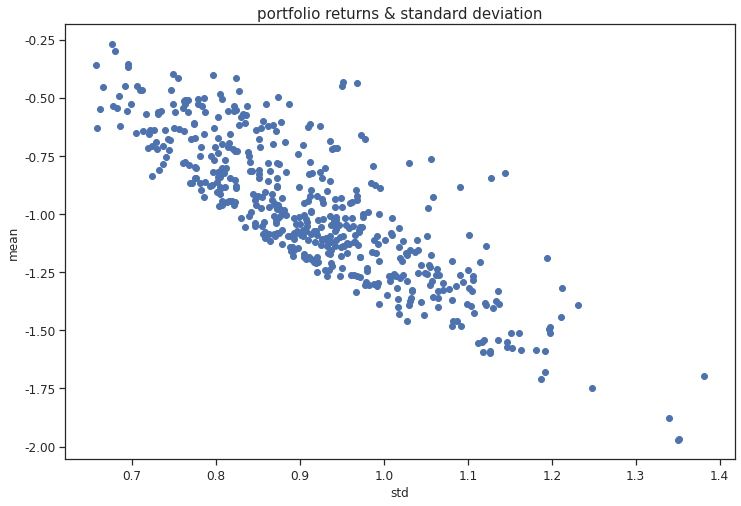

In [ ]:
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values
plt.figure(figsize = (12, 8))
plt.plot(stds, means, 'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('portfolio returns & standard deviation', fontsize = 15)

Text(0.5, 1.0, 'Minimum variance frontier for risky assets(cluster_0)')

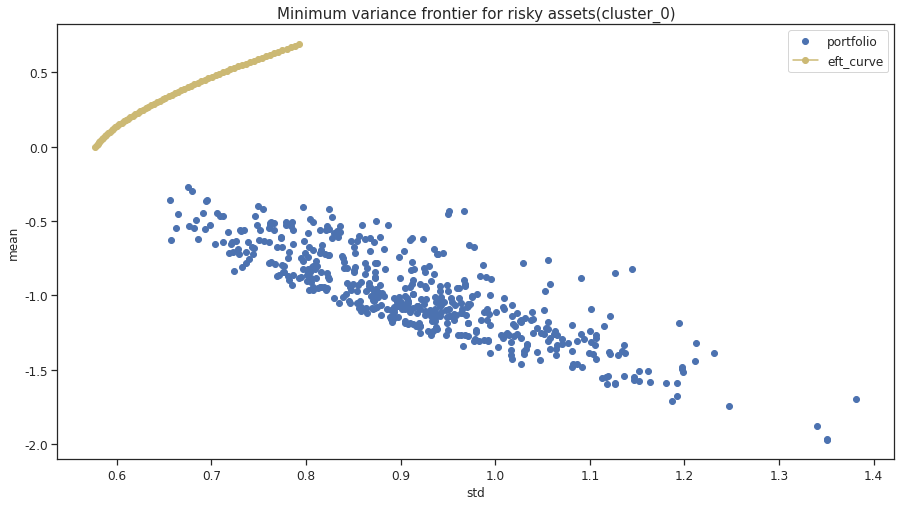

In [ ]:
def minimum_port_weight(returns):
  mean_ret = np.mean(returns,axis=1)
  cov_ret = np.cov(returns)
  n = mean_ret.shape[0]
  one_array = np.ones(n)

  #List of target portfolio returns (목표 포트폴리오 수익률 리스트) > 계속 수정
  mus = list(np.arange(0,0.7,0.01))

  # Convert to cvxopt matrices (cvxopt matrix로 변환)
  Q = opt.matrix(cov_ret)
  p = opt.matrix(0.0, (n, 1))

  # Create constraint matrices (최적화 문제 제약조건 설정)
  A = opt.matrix(np.stack((mean_ret,one_array)))
  weights_list = []
  mean_std_list = []
  for mu in mus:
    b = opt.matrix(np.array([mu,1]))
    weights = solvers.qp(Q, p, A = A, b = b)['x']
    weight_array = np.array(list(weights))
    port_ret = np.matrix(weight_array).dot(np.matrix(mean_ret).T)
    port_std = np.sqrt(np.matrix(weight_array).dot(np.matrix(cov_ret)).dot(np.matrix(weight_array).T))

    weights_list.append(list(weights))
    mean_std_list.append([port_ret[0,0],port_std[0,0]])

  return weights_list,mean_std_list

weights, mean_stds = minimum_port_weight(returns_matrix)
col_name = result_data.columns + '_Weight'
weights_df = pd.DataFrame(weights,columns = col_name)
mean_stds_df = pd.DataFrame(mean_stds,columns=['Port_ret','Port_std'])

#Plot minimum variance frontier (최소 분산 곡선 그래프)
#Random portfolios (무작위 포트폴리오)
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

#Minimum varaince portfolios (최소분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']

fig = plt.figure(figsize=(15,8))
plt.plot(stds, means, 'o', label = 'portfolio')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o', label = 'eft_curve')
plt.legend()
plt.title('Minimum variance frontier for risky assets(cluster_0)',fontsize=15)

cluster_2의 포트폴리오 작성

In [ ]:
cluster_2

,KOSPI,NASDAQ,S&P,USA_TREASURT,Nikkei,dollar,cluster
Date,,,,,,,
2003-12-02,0.05,-0.49,-0.33,-0.27,0.07,-0.28,2
2003-12-04,-0.40,0.44,0.47,-0.93,1.00,-0.20,2
2003-12-09,0.32,-2.08,-0.85,1.73,0.79,-0.24,2
2003-12-11,-0.44,1.98,1.15,-1.85,1.66,-0.55,2
2003-12-12,1.89,0.34,0.27,0.09,0.94,0.28,2
...,...,...,...,...,...,...,...
2022-11-29,1.04,-0.59,-0.16,1.22,-0.48,0.42,2
2022-11-30,1.61,4.41,3.09,-1.20,-0.21,-1.10,2
2022-12-09,0.76,-0.70,-0.73,2.18,1.18,0.19,2


In [ ]:
cluster_2.drop('cluster', axis = 1, inplace = True)
returns_matrix = cluster_2.values.T
#Generate 500 random portfolio (500개의 무작위 포트폴리오 생성)
output = []
for i in range(0,500):
  port_mean, port_std, weights = random_portfolio(returns_matrix)
  mean_std_array = np.array([port_mean, port_std])
  weights_array = np.array(weights)
  merged_array = np.concatenate((mean_std_array,weights_array),axis=None)
  merged_list = merged_array.tolist()
  output.append(merged_list)

col_list = list(result_data.columns)
col_list = [i + '_W' for i in col_list]

df_col = ['Port_ret','Port_std'] + col_list
port_ret_var = pd.DataFrame(output,columns = df_col)
port_ret_var

,Port_ret,Port_std,KOSPI_W,NASDAQ_W,S&P_W,USA_TREASURT_W,Nikkei_W,dollar_W
0,0.346226,0.473979,0.157453,0.335087,0.155616,0.057569,0.158041,0.136233
1,0.252987,0.511941,0.061293,0.187399,0.321147,0.313924,0.070377,0.045860
2,0.376277,0.475682,0.122088,0.259690,0.215732,0.062011,0.238629,0.101851
3,0.331868,0.478748,0.076200,0.174872,0.215538,0.272262,0.226516,0.034612
4,0.241131,0.394930,0.142121,0.120243,0.170737,0.221679,0.120892,0.224329
...,...,...,...,...,...,...,...,...
495,0.270090,0.551336,0.347269,0.132406,0.001112,0.415153,0.024405,0.079655
496,0.223526,0.425777,0.259331,0.129066,0.074440,0.276936,0.032389,0.227837
497,0.370752,0.442918,0.338561,0.232676,0.049430,0.086276,0.144889,0.148168
498,0.210104,0.409499,0.107621,0.205462,0.130461,0.093027,0.107204,0.356226


Text(0.5, 1.0, 'portfolio returns & standard deviation')

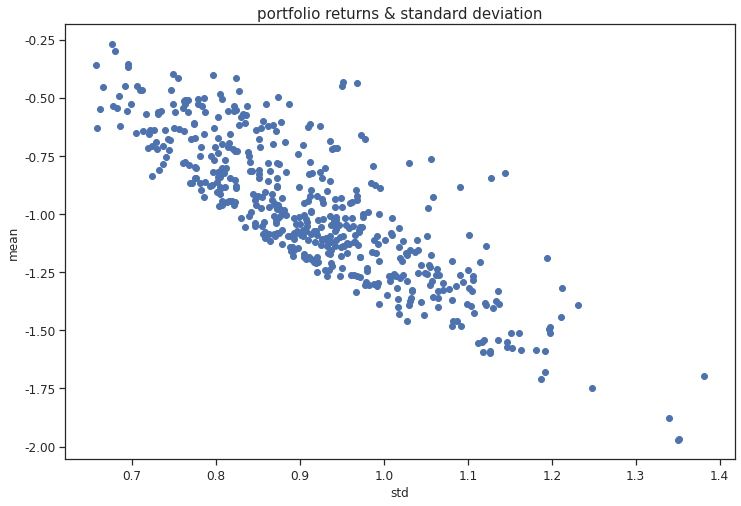

In [ ]:
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values
plt.figure(figsize = (12, 8))
plt.plot(stds, means, 'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('portfolio returns & standard deviation', fontsize = 15)

Text(0.5, 1.0, 'Minimum variance frontier for risky assets(cluster_2)')

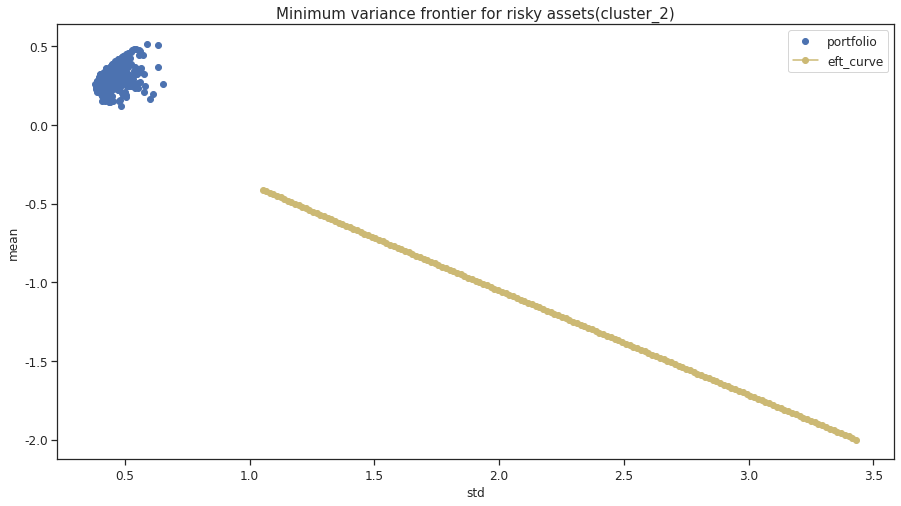

In [ ]:
def minimum_port_weight(returns):
  mean_ret = np.mean(returns,axis=1)
  cov_ret = np.cov(returns)
  n = mean_ret.shape[0]
  one_array = np.ones(n)

  #List of target portfolio returns (목표 포트폴리오 수익률 리스트) > 계속 수정
  mus = list(np.arange(-2,-0.4,0.01))

  # Convert to cvxopt matrices (cvxopt matrix로 변환)
  Q = opt.matrix(cov_ret)
  p = opt.matrix(0.0, (n, 1))

  # Create constraint matrices (최적화 문제 제약조건 설정)
  A = opt.matrix(np.stack((mean_ret,one_array)))
  weights_list = []
  mean_std_list = []
  for mu in mus:
    b = opt.matrix(np.array([mu,1]))
    weights = solvers.qp(Q, p, A = A, b = b)['x']
    weight_array = np.array(list(weights))
    port_ret = np.matrix(weight_array).dot(np.matrix(mean_ret).T)
    port_std = np.sqrt(np.matrix(weight_array).dot(np.matrix(cov_ret)).dot(np.matrix(weight_array).T))

    weights_list.append(list(weights))
    mean_std_list.append([port_ret[0,0],port_std[0,0]])

  return weights_list,mean_std_list

weights, mean_stds = minimum_port_weight(returns_matrix)
col_name = result_data.columns + '_Weight'
weights_df = pd.DataFrame(weights,columns = col_name)
mean_stds_df = pd.DataFrame(mean_stds,columns=['Port_ret','Port_std'])

#Plot minimum variance frontier (최소 분산 곡선 그래프)
#Random portfolios (무작위 포트폴리오)
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

#Minimum varaince portfolios (최소분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']

fig = plt.figure(figsize=(15,8))
plt.plot(stds, means, 'o', label = 'portfolio')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o', label = 'eft_curve')
plt.legend()
plt.title('Minimum variance frontier for risky assets(cluster_2)',fontsize=15)

In [ ]:
cluster_3.drop('cluster', axis = 1, inplace = True)
returns_matrix = cluster_3.values.T
#Generate 500 random portfolio (500개의 무작위 포트폴리오 생성)
output = []
for i in range(0,500):
  port_mean, port_std, weights = random_portfolio(returns_matrix)
  mean_std_array = np.array([port_mean, port_std])
  weights_array = np.array(weights)
  merged_array = np.concatenate((mean_std_array,weights_array),axis=None)
  merged_list = merged_array.tolist()
  output.append(merged_list)

col_list = list(result_data.columns)
col_list = [i + '_W' for i in col_list]

df_col = ['Port_ret','Port_std'] + col_list
port_ret_var = pd.DataFrame(output,columns = df_col)
port_ret_var

,Port_ret,Port_std,KOSPI_W,NASDAQ_W,S&P_W,USA_TREASURT_W,Nikkei_W,dollar_W
0,-0.801490,0.811560,0.186244,0.181353,0.235565,0.089606,0.053905,0.253326
1,-0.932786,0.949040,0.109906,0.222605,0.277161,0.100764,0.150767,0.138798
2,-1.391450,1.121749,0.298000,0.128893,0.190057,0.281538,0.100919,0.000592
3,-1.261161,1.062091,0.238980,0.238515,0.246398,0.197985,0.014482,0.063640
4,-0.864872,0.771177,0.132576,0.268231,0.055956,0.137499,0.110982,0.294756
...,...,...,...,...,...,...,...,...
495,-0.681568,0.744769,0.153988,0.026190,0.080298,0.147323,0.281140,0.311061
496,-0.822512,0.913993,0.219400,0.186188,0.089180,0.123731,0.309129,0.072372
497,-1.119465,0.964393,0.145244,0.016851,0.230124,0.230692,0.266920,0.110168
498,-0.559997,0.730412,0.252787,0.158629,0.114051,0.053582,0.182544,0.238408


Text(0.5, 1.0, 'portfolio returns & standard deviation')

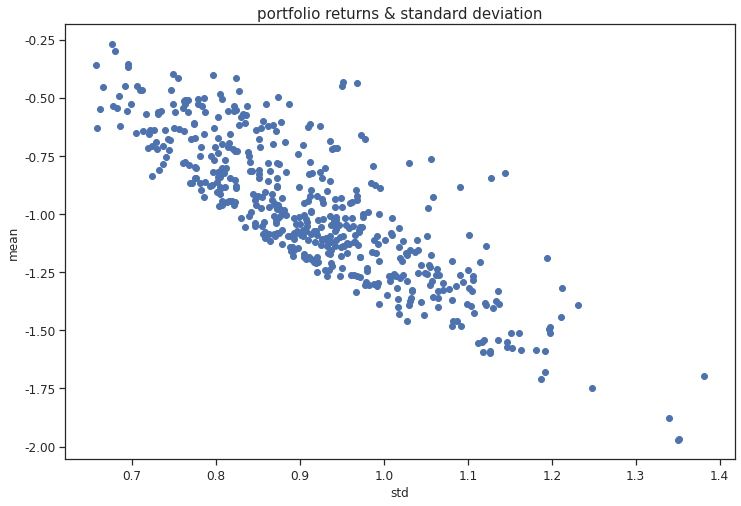

In [ ]:
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values
plt.figure(figsize = (12, 8))
plt.plot(stds, means, 'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
rc('font', family= 'Apple Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.title('portfolio returns & standard deviation', fontsize = 15)

Text(0.5, 1.0, 'Minimum variance frontier for risky assets(cluster_3)')

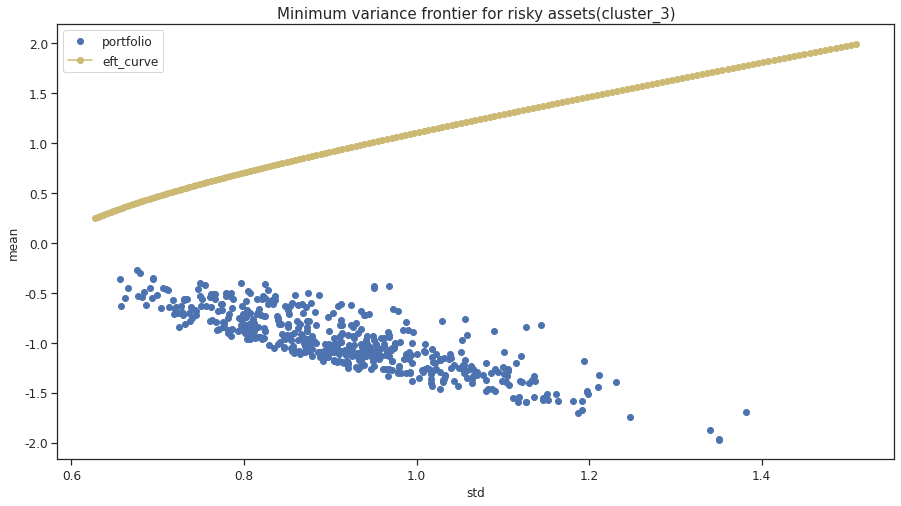

In [ ]:
def minimum_port_weight(returns):
  mean_ret = np.mean(returns,axis=1)
  cov_ret = np.cov(returns)
  n = mean_ret.shape[0]
  one_array = np.ones(n)

  #List of target portfolio returns (목표 포트폴리오 수익률 리스트)
  mus = list(np.arange(0.25,2,0.01))

  # Convert to cvxopt matrices (cvxopt matrix로 변환)
  Q = opt.matrix(cov_ret)
  p = opt.matrix(0.0, (n, 1))

  # Create constraint matrices (최적화 문제 제약조건 설정)
  A = opt.matrix(np.stack((mean_ret,one_array)))
  weights_list = []
  mean_std_list = []
  for mu in mus:
    b = opt.matrix(np.array([mu,1]))
    weights = solvers.qp(Q, p, A = A, b = b)['x']
    weight_array = np.array(list(weights))
    port_ret = np.matrix(weight_array).dot(np.matrix(mean_ret).T)
    port_std = np.sqrt(np.matrix(weight_array).dot(np.matrix(cov_ret)).dot(np.matrix(weight_array).T))

    weights_list.append(list(weights))
    mean_std_list.append([port_ret[0,0],port_std[0,0]])

  return weights_list,mean_std_list

weights, mean_stds = minimum_port_weight(returns_matrix)
col_name = result_data.columns + '_Weight'
weights_df = pd.DataFrame(weights,columns = col_name)
mean_stds_df = pd.DataFrame(mean_stds,columns=['Port_ret','Port_std'])

#Plot minimum variance frontier (최소 분산 곡선 그래프)
#Random portfolios (무작위 포트폴리오)
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values

#Minimum varaince portfolios (최소분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']

fig = plt.figure(figsize=(15,8))
plt.plot(stds, means, 'o', label = 'portfolio')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o', label = 'eft_curve')
plt.legend()
plt.title('Minimum variance frontier for risky assets(cluster_3)',fontsize=15)

### 결론


In [ ]:
- 수익률: 군집3>군집2>군집1>군집0
- 표준화: 군집3>군집1>군집2>군집0